# U-Net Model Training for Fault Segmentation (PyTorch)

## Step 1: Import Libraries

"First, we import all the necessary libraries. This includes standard libraries like `os` and `numpy`, deep learning libraries from `tensorflow.keras`, and the custom modules `DataGenerator` and `unet` from our project.

In [1]:
import os
import shutil
from datetime import datetime
import numpy as np
import matplotlib.pyplot as plt

# PyTorch imports
import torch
import torch.nn as nn
from torch.utils.data import DataLoader
from torch.utils.tensorboard import SummaryWriter
import torch.optim as optim

# Project‑local code
from utils_pytorch import DataGenerator
from unet3_pytorch import unet, cross_entropy_balanced

2025-07-29 06:18:50.924045: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:467] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1753762730.943079  171148 cuda_dnn.cc:8579] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1753762730.948818  171148 cuda_blas.cc:1407] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
W0000 00:00:1753762730.963821  171148 computation_placer.cc:177] computation placer already registered. Please check linkage and avoid linking the same target more than once.
W0000 00:00:1753762730.963869  171148 computation_placer.cc:177] computation placer already registered. Please check linkage and avoid linking the same target more than once.
W0000 00:00:1753762730.963871  171148 computation_placer.cc:177] computation placer alr

## Step 1a: Verify GPU Availability
This cell checks if TensorFlow can detect a GPU. If a GPU is available, it enables memory growth to prevent TensorFlow from allocating all of the GPU's memory at once.

In [2]:
# Check whether CUDA is available and configure deterministic behaviour.
if torch.cuda.is_available():
    device = torch.device("cuda")
    print(f"GPU detected -> using {torch.cuda.get_device_name(0)}")
    # (Optional) set cudnn benchmark / deterministic flags according to your needs
    torch.backends.cudnn.benchmark = True
else:
    device = torch.device("cpu")
    print("No GPU detected.  Running on CPU.")

GPU detected -> using NVIDIA RTX A5000


## Step 2: Define Paths and Parameters

In [3]:
base_dir = "/home/roderickperez/DS_PROJECTS/faultSeg/faultSeg_Wu_2019_Keras"

# (all the exact same path definitions as before) ---------------------------
original_data_dir   = os.path.join(base_dir, "data_from_Wu")
train_seis_dir      = os.path.join(original_data_dir, "train/seis")
train_fault_dir     = os.path.join(original_data_dir, "train/fault")
validation_seis_dir = os.path.join(original_data_dir, "validation/seis")
validation_fault_dir= os.path.join(original_data_dir, "validation/fault")

processed_data_dir  = os.path.join(base_dir, "data_processed_npy")
train_dir_new       = os.path.join(processed_data_dir, "train")
validation_dir_new  = os.path.join(processed_data_dir, "validation")

model_dir       = os.path.join(base_dir, "model")
log_dir         = os.path.join(base_dir, "logs_pytorch")
checkpoint_dir  = os.path.join(base_dir, "checkpoints_pytorch")

In [ ]:
# --- Training Parameters ---
params = {
    'batch_size' : 1,          # effective batch (original + flipped)
    'dim'        : (128,128,128),
    'n_channels' : 1,
    'shuffle'    : True
}
epochs         = 10
learning_rate  = 1e-4

## Step 3: Prepare Data

This step involves converting the original `.dat` files into the `.npy` format that our `DataGenerator` expects. We also split the data into training and validation sets. This is a crucial preprocessing step.

In [5]:
def convert_dat_to_npy():
    """
    Read every *.dat* volume, reshape to (128,128,128) and save it as a
    proper *.npy* file.  The new files include the NumPy header, so they
    can be loaded with np.load() (the allow_pickle issue disappears).
    """
    # ------------------------------------------------------------------
    # 1) start from a clean processed-data directory
    # ------------------------------------------------------------------
    if os.path.exists(processed_data_dir):
        shutil.rmtree(processed_data_dir)
        print(f"Removed old processed data directory: {processed_data_dir}")

    for path in [
        os.path.join(train_dir_new, 'seis'),
        os.path.join(train_dir_new, 'fault'),
        os.path.join(validation_dir_new, 'seis'),
        os.path.join(validation_dir_new, 'fault'),
        model_dir, log_dir, checkpoint_dir
    ]:
        os.makedirs(path, exist_ok=True)

    # ------------------------------------------------------------------
    # 2) helper that does the actual conversion
    # ------------------------------------------------------------------
    def process_files(file_list, src_seis, src_fault, dst_root):
        for fname in file_list:
            # --- seismic cube ------------------------------------------------
            seis = np.fromfile(os.path.join(src_seis,  fname),
                               dtype=np.single).reshape(params['dim'])
            np.save(os.path.join(dst_root, 'seis',
                                 fname.replace('.dat', '.npy')), seis)

            # --- fault labels -----------------------------------------------
            fault = np.fromfile(os.path.join(src_fault, fname),
                                dtype=np.single).reshape(params['dim'])
            np.save(os.path.join(dst_root, 'fault',
                                 fname.replace('.dat', '.npy')), fault)
        print(f"Processed {len(file_list):>4} files  ->  {dst_root}")

    # ------------------------------------------------------------------
    # 3) run conversion for train / validation splits
    # ------------------------------------------------------------------
    train_files = [f for f in os.listdir(train_seis_dir) if f.endswith('.dat')]
    val_files   = [f for f in os.listdir(validation_seis_dir) if f.endswith('.dat')]

    process_files(train_files, train_seis_dir,      train_fault_dir,      train_dir_new)
    process_files(val_files,   validation_seis_dir, validation_fault_dir, validation_dir_new)

# --------------------------------------------------------------------------
# call it once
# --------------------------------------------------------------------------
convert_dat_to_npy()


Removed old processed data directory: /home/roderickperez/DS_PROJECTS/faultSeg/faultSeg_Wu_2019_Keras/data_processed_npy
Processed  200 files  ->  /home/roderickperez/DS_PROJECTS/faultSeg/faultSeg_Wu_2019_Keras/data_processed_npy/train
Processed   20 files  ->  /home/roderickperez/DS_PROJECTS/faultSeg/faultSeg_Wu_2019_Keras/data_processed_npy/validation


## Step 4: Create Data Generators

Now that our data is in the correct format and location, we can use the `DataGenerator` from `utils.py` to feed it to our model efficiently. We create one generator for the training set and one for the validation set.

In [6]:
# Build PyTorch datasets & loaders
train_ID = [os.path.splitext(f)[0] for f in os.listdir(os.path.join(train_dir_new, "seis"))]
valid_ID = [os.path.splitext(f)[0] for f in os.listdir(os.path.join(validation_dir_new, "seis"))]

train_dataset = DataGenerator(dpath=os.path.join(train_dir_new, 'seis/'),
                              fpath=os.path.join(train_dir_new, 'fault/'),
                              data_IDs=train_ID,
                              dim=params['dim'])
valid_dataset = DataGenerator(dpath=os.path.join(validation_dir_new, 'seis/'),
                              fpath=os.path.join(validation_dir_new, 'fault/'),
                              data_IDs=valid_ID,
                              dim=params['dim'])

train_loader = DataLoader(train_dataset, batch_size=1, shuffle=params['shuffle'], num_workers=4)
valid_loader = DataLoader(valid_dataset, batch_size=1, shuffle=False,             num_workers=4)

print("Number of training pairs :", len(train_ID))
print("Number of validation pairs:", len(valid_ID))


Number of training pairs : 200
Number of validation pairs: 20


## Step 5: Build and Compile the Model

We will now use the `unet` function from `unet3.py` to build our model architecture. After building it, we compile it with an optimizer, a loss function, and metrics to monitor.

In [7]:
model = unet().to(device)
optimiser = optim.Adam(model.parameters(), lr=learning_rate)
criterion = cross_entropy_balanced

print(f"Model has {sum(p.numel() for p in model.parameters() if p.requires_grad):,} trainable parameters")


Model has 1,459,585 trainable parameters


In [8]:
# Torch equivalent of callbacks
writer = SummaryWriter(log_dir)
os.makedirs(checkpoint_dir, exist_ok=True)

def save_ckpt(epoch):
    fname = os.path.join(checkpoint_dir, f"fseg-{epoch:02d}.pth")
    torch.save(model.state_dict(), fname)


## Step 6: Train the Model

With everything set up, we can now start training the model using the `fit` method. The training and validation data will be provided through our generators.

In [9]:
history = {'loss': [], 'val_loss': [], 'accuracy': [], 'val_accuracy': []}

for epoch in range(1, epochs + 1):
    # ---- training ----
    model.train()
    epoch_loss, epoch_acc = 0.0, 0.0
    for X, Y in train_loader:
        X, Y = X.to(device), Y.to(device)
        optimiser.zero_grad()
        preds = model(X)
        loss  = criterion(preds, Y)
        loss.backward()
        optimiser.step()

        epoch_loss += loss.item()
        epoch_acc  += (preds.round() == Y).float().mean().item()

    epoch_loss /= len(train_loader)
    epoch_acc  /= len(train_loader)
    history['loss'].append(epoch_loss)
    history['accuracy'].append(epoch_acc)
    writer.add_scalar('Loss/train',  epoch_loss, epoch)
    writer.add_scalar('Acc/train',   epoch_acc,  epoch)

    # ---- validation ----
    model.eval()
    val_loss, val_acc = 0.0, 0.0
    with torch.no_grad():
        for X, Y in valid_loader:
            X, Y = X.to(device), Y.to(device)
            preds = model(X)
            loss  = criterion(preds, Y)
            val_loss += loss.item()
            val_acc  += (preds.round() == Y).float().mean().item()

    val_loss /= len(valid_loader)
    val_acc  /= len(valid_loader)
    history['val_loss'].append(val_loss)
    history['val_accuracy'].append(val_acc)
    writer.add_scalar('Loss/val',  val_loss, epoch)
    writer.add_scalar('Acc/val',   val_acc,  epoch)

    print(f"Epoch {epoch:02d}/{epochs} | "
          f"loss {epoch_loss:.4f} – acc {epoch_acc:.4f} | "
          f"val_loss {val_loss:.4f} – val_acc {val_acc:.4f}")

    save_ckpt(epoch)

writer.close()


Epoch 01/10 | loss 0.0716 – acc 0.7242 | val_loss 0.0565 – val_acc 0.8735
Epoch 02/10 | loss 0.0509 – acc 0.8206 | val_loss 0.0438 – val_acc 0.8747
Epoch 03/10 | loss 0.0427 – acc 0.8540 | val_loss 0.0375 – val_acc 0.8891
Epoch 04/10 | loss 0.0365 – acc 0.8779 | val_loss 0.0325 – val_acc 0.8924
Epoch 05/10 | loss 0.0321 – acc 0.8949 | val_loss 0.0298 – val_acc 0.9040
Epoch 06/10 | loss 0.0294 – acc 0.9048 | val_loss 0.0284 – val_acc 0.9178
Epoch 07/10 | loss 0.0266 – acc 0.9131 | val_loss 0.0272 – val_acc 0.9236
Epoch 08/10 | loss 0.0253 – acc 0.9174 | val_loss 0.0262 – val_acc 0.9123
Epoch 09/10 | loss 0.0234 – acc 0.9227 | val_loss 0.0257 – val_acc 0.9228
Epoch 10/10 | loss 0.0223 – acc 0.9255 | val_loss 0.0242 – val_acc 0.9211


## Step 7: Save the Final Model

After training is complete, we save the final model to the `model` directory for future use.

In [10]:
now = datetime.now().strftime("%Y-%m-%d_%H-%M-%S")
model_name = f"unet_pytorch_model_{len(train_ID)}pairs_{epochs}epochs_{now}.pth"
model_path = os.path.join(model_dir, model_name)
torch.save(model.state_dict(), model_path)
print(f"Final model saved to: {model_path}")

Final model saved to: /home/roderickperez/DS_PROJECTS/faultSeg/faultSeg_Wu_2019_Keras/model/unet_pytorch_model_200pairs_10epochs_2025-07-29_06-27-12.pth


## Step 8: Visualize Training History

Finally, we visualize the training and validation accuracy and loss over the epochs. This helps us understand how well the model has learned.

Plotting training history...
History plot saved to: /home/roderickperez/DS_PROJECTS/faultSeg/faultSeg_Wu_2019_Keras/model/unet_pytorch_model_200pairs_10epochs_2025-07-29_06-27-12_history.png


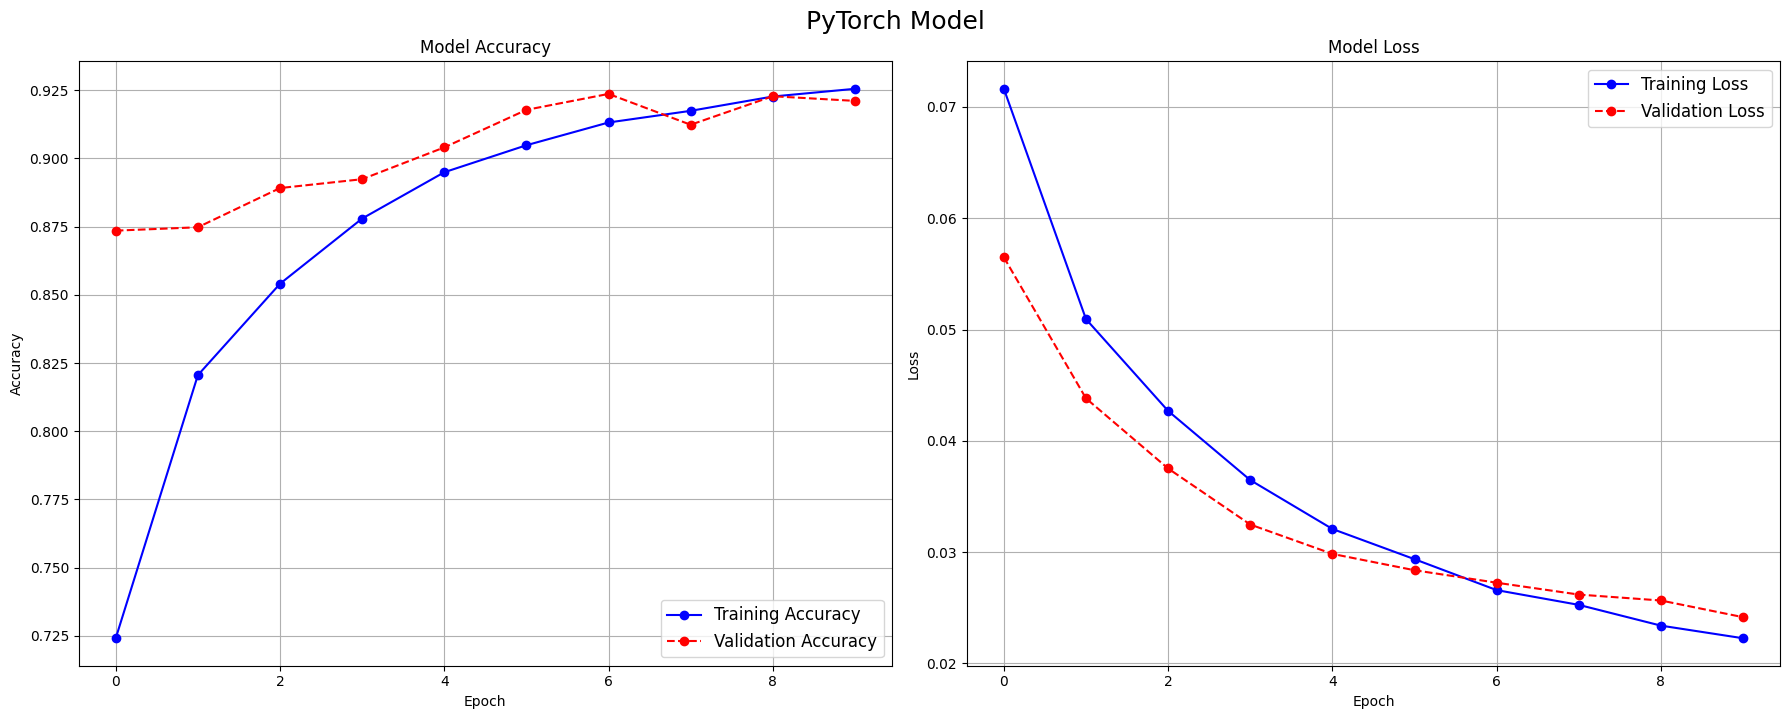

In [16]:
def show_history(hist, save_path=None):
    print("Plotting training history...")
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(18, 7))

    ax1.plot(hist['accuracy'],     label='Training Accuracy', color='b', marker='o')
    ax1.plot(hist['val_accuracy'], label='Validation Accuracy', color='r', marker='o', linestyle='--')
    ax1.set_title('Model Accuracy')
    ax1.set_xlabel('Epoch')
    ax1.set_ylabel('Accuracy')
    ax1.legend(loc='lower right', fontsize=12)
    ax1.grid(True)

    ax2.plot(hist['loss'],     label='Training Loss', color='b', marker='o')
    ax2.plot(hist['val_loss'], label='Validation Loss', color='r', marker='o', linestyle='--')
    ax2.set_title('Model Loss')
    ax2.set_xlabel('Epoch')
    ax2.set_ylabel('Loss')
    ax2.legend(loc='upper right', fontsize=12)
    ax2.grid(True)

    plt.tight_layout()
    plt.suptitle('PyTorch Model', fontsize = 18, y = 1.02)
    if save_path:
        plt.savefig(save_path)
        print(f"History plot saved to: {save_path}")
    plt.show()

plot_path = os.path.join(model_dir, model_name.replace(".pth", "_history.png"))
show_history(history, save_path=plot_path)
